# Variational autoencoders

A tutorial by Alexander Cai. See [website](https://notes.adzc.ai/70+Statistics+and+Machine+Learning/75+Unsupervised+Learning+and+Generative+Modelling/variational+autoencoders) for notes.

Here I'm using Jax since the functional form makes everything very clear and it's also very fast. You can essentially just use NumPy for all the calculations if you're willing to do the gradient step by hand.

The only other Jax idiosyncrasy to note is that we pass around "key"s for pseudorandum number generation. This also makes it very easy to tell which functions require stochasticity and which ones are deterministic.

I'm also using the Julia convention of writing out the actual Greek letters.

In [ ]:
import jax
from jax import numpy as jnp
from jax import random

# we never use jax.nn since we're cool

from torchvision.datasets import MNIST  # data

from matplotlib import pyplot as plt

from functools import partial
from dataclasses import dataclass
from tqdm import trange

## Autoencoders

Just a simple one-hidden-layer neural network for the encoder and decoder.

In [ ]:
def relu(x):
    return jnp.maximum(x, 0)

def encode(φ, x):
    hidden = relu(jnp.dot(φ['fc'], x) + φ['b'])
    μ = jnp.dot(φ['fc_mu'], hidden) + φ['b_mu']
    log_Σ = jnp.dot(φ['fc_log_var'], hidden) + φ['b_log_var']
    return μ, log_Σ

def sample(μ, log_Σ, key):
    """sample from a normal distribution with the given mean and elementwise log variance."""
    ε = random.normal(key, μ.shape)
    σ = jnp.exp(log_Σ / 2.)
    return μ + ε * σ

def decode(θ, z):
    """takes in a latent vector (or a bunch of them) and returns a **distribution** over images.
    (i.e. each element of the resulting matrix is the _probability_ that that pixel is white)"""
    out = jnp.tanh(jnp.dot(θ['fc_1'], z) + θ['b_1'])
    out = jnp.dot(θ['fc_2'], out) + θ['b_2']
    return jax.lax.logistic(out)


## optimization

See the post for the reconstruction and regularization terms defined for our task.

In [ ]:
def reconstruct(params, x, key):
    """Feed an image through the whole "hourglass".
    Returns an "image" (but actually a distribution over images, see `decode`)"""
    μ, log_Σ = encode(params['encoder'], x)
    z = sample(μ, log_Σ, key)
    return decode(params['decoder'], z), μ, log_Σ

@partial(jax.vmap, in_axes=(None, 0, 0))  # use the same parameters across every (x, key)
def elbo(params, x, key):
    out_bernoulli, μ, log_Σ = reconstruct(params, x, key)
    reconstruction = jnp.sum(x * jnp.log(out_bernoulli) + (1 - x) * jnp.log(1 - out_bernoulli))
    regularization = .5 * jnp.sum(1 + log_Σ - μ ** 2 - jnp.exp(log_Σ))
    return reconstruction + regularization  # want to maximize both of these

@jax.value_and_grad
def elbo_batch(params, x, key):
    keys = random.split(key, len(x))
    elbos = elbo(params, x, keys)
    return jnp.mean(elbos)

@jax.jit
def update(params, x, key, lr):
    """Do gradient ascent on the ELBO"""
    mean_loss, params_grads = elbo_batch(params, x, key)
    return mean_loss, jax.tree_map(lambda param, grad: param + lr * grad, params, params_grads)

def optimize(params, data, key, epochs=10, batch_size=64, lr_init=.03):
    elbos = []

    for epoch in range(epochs):
        key, subkey = random.split(key)
        data = random.permutation(subkey, data)
        lr = lr_init * ((epochs - epoch) / epochs)  # linear learning rate decay

        for i in trange(0, len(data), batch_size, desc=f'Epoch {epoch+1}/{epochs}'):
            batch = data[i:i+batch_size]
            key, subkey = random.split(key)
            elbo, params = update(params, batch, subkey, lr)
            elbos.append(elbo)

    return elbos, params

## model config and parameter initialization

In [ ]:
@dataclass
class Config:
    d_input: int
    d_encoder_hidden: int
    d_latent: int
    d_decoder_hidden: int

def initialize(key, shape):
    """
    Fan-avg glorot initialization, i.e. each element is normal.
    Mean is zero, variance is the reciprocal of the average of input and output dimension.
    """
    m, n = shape
    σ = jnp.sqrt(2 / (m + n))
    return σ * random.normal(key, shape)

def init_params(config, key):
    n = initialize
    keys = random.split(key, 5)
    params = {
        'encoder': {
            'fc': n(keys[0], (config.d_encoder_hidden, config.d_input)),
            'b': jnp.zeros(config.d_encoder_hidden),
            'fc_mu': n(keys[1], (config.d_latent, config.d_encoder_hidden)),
            'b_mu': jnp.zeros(config.d_latent),
            'fc_log_var': n(keys[2], (config.d_latent, config.d_encoder_hidden)),
            'b_log_var': jnp.zeros(config.d_latent),
        },
        'decoder': {
            'fc_1': n(keys[3], (config.d_decoder_hidden, config.d_latent)),
            'b_1': jnp.zeros(config.d_decoder_hidden),
            'fc_2': n(keys[4], (config.d_input, config.d_decoder_hidden)),
            'b_2': jnp.zeros(config.d_input),
        },
    }
    return params

## Training on MNIST

In [ ]:
dataset = MNIST('./data', download=True, train=True)
data = jnp.array(dataset.data).reshape(-1, 28*28) / 255.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 6/6: 100%|██████████| 938/938 [00:02<00:00, 467.00it/s]


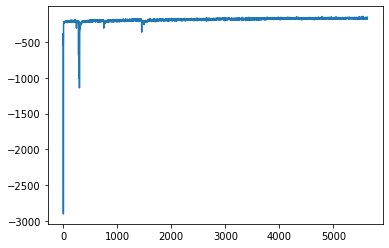

In [ ]:
config = Config(
    d_input=28*28,
    d_encoder_hidden=128,
    d_latent=2,
    d_decoder_hidden=128,
)

key = random.PRNGKey(42)

key, key_optimize, key_config = random.split(key, 3)
elbos, params = optimize(
    params=init_params(config, key_config),
    data=data,
    key=key_optimize,
    epochs=6,
    batch_size=64,
)

plt.plot(elbos)
plt.title('ELBO per batch')
plt.xlabel('batch')
plt.ylabel('ELBO')
plt.show()

## Visualizations

In [ ]:
@jax.jit
def generate(params, key, latent=None):
    '''randomly sample from the latent space and decode the image'''
    φ = params['decoder']
    if latent is None:
        d_latent = φ['fc_1'].shape[1]
        latent = random.normal(key, (d_latent,))
    image = decode(φ, latent)
    return image.reshape(28, 28)

def visualize(params, key):
    """generate 5 x 5 random images and plot them"""
    fig, axes = plt.subplots(5, 5, figsize=(5, 5))
    for i in range(5):
        for j in range(5):
            key, subkey = random.split(key)
            image = generate(params, subkey)
            axes[i, j].imshow(image)
            axes[i, j].axis('off')
    plt.show()

def visualize_reconstruct(params, data, key, n=5):
    """feed in a bunch of images and their reconstructed versions"""
    fig, axes = plt.subplots(2, n, figsize=(n, 2))
    images = random.choice(key, data, (n,))
    keys = random.split(key, n)
    for i in range(n):
        out, _, _ = reconstruct(params, images[i], keys[i])
        axes[0, i].imshow(images[i].reshape(28, 28))
        axes[1, i].imshow(out.reshape(28, 28))
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    plt.show()

def visualize_interpolate(params, key, z1=None, z2=None):
    '''interpolate through two points in the latent space'''
    φ = params['decoder']
    d_latent = φ['fc_1'].shape[1]
    if z1 is None:
        key, subkey = random.split(key)
        z1 = random.normal(subkey, (d_latent,))
    if z2 is None:
        key, subkey = random.split(key)
        z2 = random.normal(subkey, (d_latent,))
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    for i in range(10):
        latent = z1 + (i/9) * (z2 - z1)
        image = decode(φ, latent)
        axes[i].imshow(image.reshape(28, 28))
        axes[i].axis('off')
    plt.show()

decode_batch = jax.jit(jax.vmap(decode, in_axes=(None, 0)))

def visualize_manifold(params, key, n=15):
    '''visualize the latent space'''
    φ = params['decoder']
    d_latent = φ['fc_1'].shape[1]
    assert d_latent == 2, 'latent space must be 2-dimensional'
    grid = jnp.mgrid[-2:2:15j, -2:2:15j].reshape(2, -1).T
    images = decode_batch(φ, grid)
    fig, axes = plt.subplots(n, n, figsize=(n, n))
    for i in range(n):
        for j in range(n):
            img = images[i*n + j].reshape(28, 28)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
    plt.show()

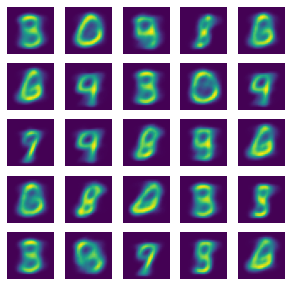

In [ ]:
key, subkey = random.split(key)
visualize(params, subkey)

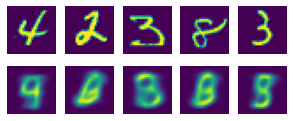

In [ ]:
key, subkey = random.split(key)
visualize_reconstruct(params, data, subkey)

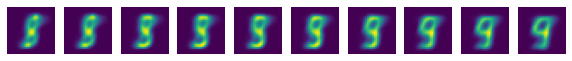

In [ ]:
key, subkey = random.split(key)
visualize_interpolate(params, subkey)

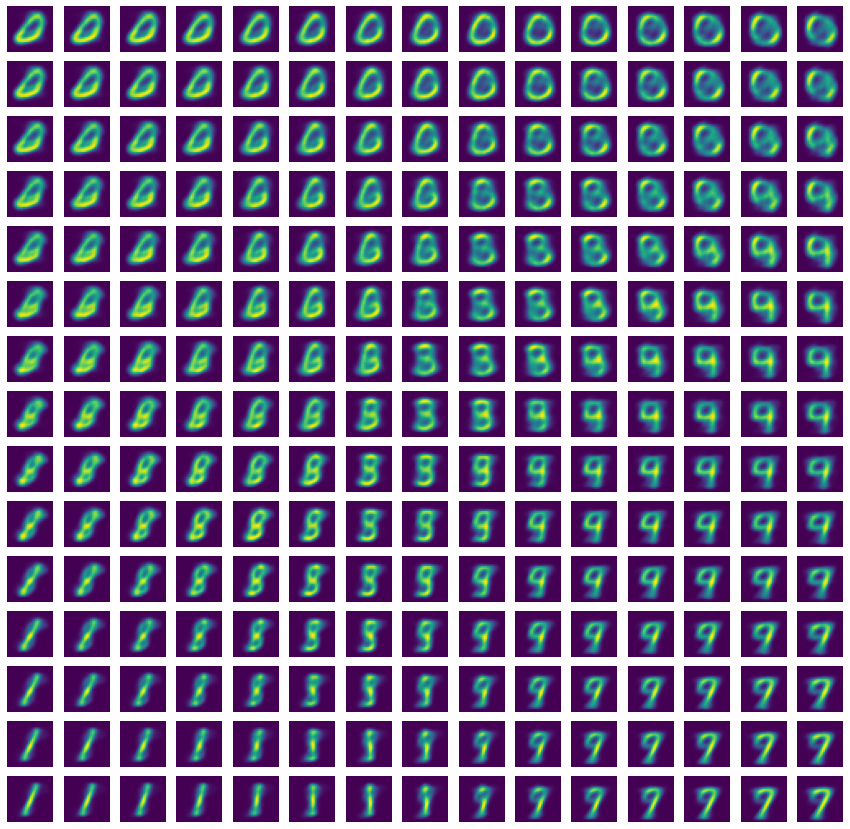

In [ ]:
key, subkey = random.split(key)
visualize_manifold(params, subkey)